## Attempt 3 

GPs are hard to scale, and solving problems with more than 1000 samples can be very challenging. One way to scale is to use GPUs, which can allow scaling upto 10K points and maybe 100K points with multiple GPUs. Here we try simpler methods. 

To get around this obstacle we can use different strategies to retrieve 1000 points from the data set. There are three ways:
- Squarish boxes strategy: make boxes with ~1000 points, map for the box, and then keep moving over the domain. Each box has a few dives and as part of the depth range.
- Long rectangle strategy: cover large number of dives, but over very few depth levels.
- Stochastic : randomly select 1000 points from some range of dives. 

Each strategy has potential pros and cons. Here we use the stochastic method and use GPy library. 


In [6]:
import numpy as np
import GPy
import xarray as xr
import gsw 

from matplotlib import pyplot as plt
from cmocean import cm as cmo
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

dens_659 = gsw.sigma0(ds_659.salinity, ds_659.temperature)
dens_660 = gsw.sigma0(ds_660.salinity, ds_660.temperature)
ds_659['density'] = xr.DataArray(
            data=dens_659,
            coords=ds_659.coords,
            dims=ds_659.dims,
            name='density'
        )

ds_660['density'] = xr.DataArray(
            data=dens_660,
            coords=ds_660.coords,
            dims=ds_660.dims,
            name='density'
        )

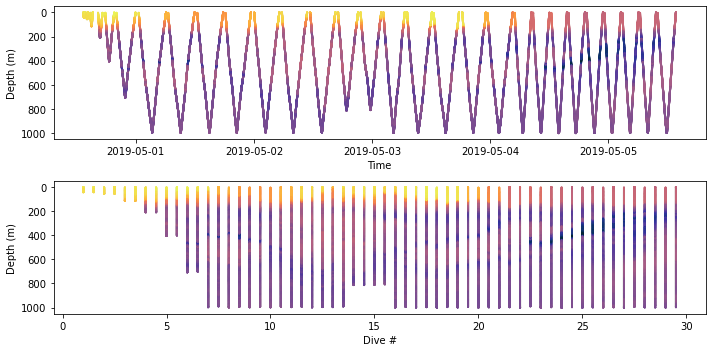

In [15]:
ndives = 30

plt.figure(figsize=(10, 5))

plt.subplot(211)
plt.scatter(ds_659.time.where(ds_659.dives<ndives, drop=True), 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Time')
plt.ylabel('Depth (m)')

plt.subplot(212)
plt.scatter(ds_659.dives.where(ds_659.dives<ndives, drop=True), 
            ds_659.pressure.where(ds_659.dives<ndives, drop=True), 
            c = ds_659.temperature.where(ds_659.dives<ndives, drop=True), 
            s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

plt.xlabel('Dive #')
plt.ylabel('Depth (m)')
plt.tight_layout()

In [27]:
# Select some data

npts = 1000

dive_start = 7
dive_end = 30

ds_659_sel= ds_659.where(ds_659.dives<dive_end 
                        ).where(ds_659.dives>dive_start
                               ).dropna('ctd_data_point')


In [28]:
ds_659_sel

<xarray.Dataset>
Dimensions:      (ctd_data_point: 68913)
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure     (ctd_data_point) float64 991.3 990.8 990.3 ... 0.4654 0.3895
    latitude     (ctd_data_point) float64 -51.36 -51.36 -51.36 ... -51.24 -51.24
    longitude    (ctd_data_point) float64 30.48 30.48 30.48 ... 32.14 32.14
    temperature  (ctd_data_point) float64 2.079 2.081 2.081 ... 2.433 2.557 2.56
    salinity     (ctd_data_point) float64 34.69 34.69 34.69 ... 33.85 33.88
    dives        (ctd_data_point) float64 7.5 7.5 7.5 7.5 ... 29.5 29.5 29.5
    time         (ctd_data_point) datetime64[ns] 2019-05-01T03:24:39.70099635...
    density      (ctd_data_point) float64 27.59 27.59 27.59 ... 26.88 26.91

In [41]:
# convert time to days+fraction
time_659 = ds_659_sel.time - np.datetime64('2019-01-01')
time_659 = (time_659 / np.timedelta64(1,'D'))

In [150]:
nstep = 100
time_sel = time_659[0:-1:nstep]
pressure_sel = ds_659_sel.pressure[0:-1:nstep]
density_sel = ds_659_sel.density[0:-1:nstep]
temperature_sel = ds_659_sel.temperature[0:-1:nstep]

In [151]:
time_sel

<xarray.DataArray 'time' (ctd_data_point: 690)>
array([120.14212617, 120.14791321, 120.15370024, 120.15948728,
       120.16527432, 120.17106135, 120.17684839, 120.18263543,
       120.18842247, 120.19420951, 120.19999654, 120.20578366,
       120.21157067, 120.21735772, 120.22314475, 120.22893172,
       120.23471883, 120.24050587, 120.24629287, 120.25207994,
       120.27548272, 120.28126976, 120.28705679, 120.29284382,
       120.29863087, 120.30441786, 120.31020494, 120.31599191,
       120.32177895, 120.32756598, 120.33335302, 120.33914006,
       120.34492709, 120.35071414, 120.35650117, 120.36228821,
       120.36807524, 120.37386228, 120.37964932, 120.38694098,
       120.39272803, 120.39851507, 120.40430209, 120.41008913,
       120.41587617, 120.42166321, 120.42745024, 120.43323728,
       120.43902432, 120.44481135, 120.45059847, 120.4563855 ,
       120.46217253, 120.46795957, 120.47374661, 120.47953365,
       120.48532067, 120.49110772, 120.49689476, 120.52551744,
       120.53130448, 120.53709152, 120.54287852, 120.54866559,
       120.55445263, 120.56023959, 120.56602664, 120.57181368,
       120.57760071, 120.58338774, 120.58917478, 120.59496182,
       120.60074887, 120.60653589, 120.61232293, 120.61810997,
       120.623897  , 120.63122339, 120.63701043, 120.64279747,
...
       124.08000942, 124.08579646, 124.09158348, 124.09737052,
       124.10315755, 124.12104985, 124.12683687, 124.13262394,
       124.13841089, 124.14419793, 124.14998497, 124.155772  ,
       124.16155905, 124.16734608, 124.17313312, 124.17892015,
       124.18673944, 124.19252649, 124.19831354, 124.20410057,
       124.2098876 , 124.21567463, 124.22146169, 124.22724869,
       124.23303576, 124.23882277, 124.24460983, 124.25039687,
       124.26851513, 124.27430216, 124.2800892 , 124.28587624,
       124.29166321, 124.29745024, 124.30323728, 124.30902432,
       124.31481135, 124.32059839, 124.32638544, 124.33217248,
       124.33931374, 124.34510078, 124.35088781, 124.35667481,
       124.36246189, 124.36824892, 124.37403596, 124.37982299,
       124.38560998, 124.39139707, 124.39718412, 124.41690632,
       124.4226933 , 124.42848042, 124.43426744, 124.44005448,
       124.44584145, 124.45162848, 124.45741552, 124.46320256,
       124.46898959, 124.47477663, 124.48056367, 124.48635071,
       124.49509374, 124.50088078, 124.50666781, 124.51245485,
       124.51824189, 124.52402892, 124.52981596, 124.535603  ,
       124.54139005, 124.54717707, 124.55296407, 124.55875115,
       124.56453821, 124.57032524])
Dimensions without coordinates: ctd_data_point

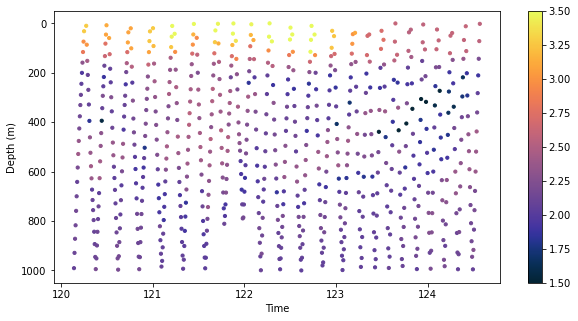

In [152]:
ndives = 30

plt.figure(figsize=(10, 5))

plt.subplot(111)
plt.scatter(time_sel, 
            pressure_sel, 
            c = temperature_sel, 
            s=10, cmap=cmo.thermal, vmin=1.5, vmax=3.5)

plt.gca().invert_yaxis()

plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.colorbar()

In [153]:
nsampes = len(time_sel)
X2 = np.zeros((nsampes,2))
Y =  np.zeros((nsampes,1))

X2[:,0] = time_sel
X2[:,1] = pressure_sel

Y[:,0] = temperature_sel

In [169]:
kRBF = GPy.kern.RBF(2, active_dims=[0,1], ARD=True)
kMATERN32 = GPy.kern.Matern32(2, active_dims=[0,1], ARD=True)

mRBF = GPy.models.GPRegression(X2, Y, kRBF)
mMATERN32 = GPy.models.GPRegression(X2, Y, kMATERN32)

In [155]:
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,"(2,)",+ve,


In [156]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [157]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.00000000,+ve,
[1],1.00000000,+ve,


In [158]:
m.optimize_restarts(5)

Optimization restart 1/5, f = -281.2804111792947
Optimization restart 2/5, f = -281.28041116100144
Optimization restart 3/5, f = -281.28040939835387
Optimization restart 4/5, f = -281.2804111408985
Optimization restart 5/5, f = -281.28041115888016


In [171]:
mRBF.optimize_restarts(5)

Optimization restart 1/5, f = -281.2804111792947
Optimization restart 2/5, f = -185.04242074097397
Optimization restart 3/5, f = -281.28041110576225
Optimization restart 4/5, f = -281.2804111662964
Optimization restart 5/5, f = -281.28041116554846


In [170]:
mMATERN32.optimize_restarts(5)

Optimization restart 1/5, f = -384.9111894104034
Optimization restart 2/5, f = -384.91118937075413
Optimization restart 3/5, f = -230.9810195938005
Optimization restart 4/5, f = -138.4865697485023
Optimization restart 5/5, f = -144.66793216405625


In [174]:
mRBF

GP_regression.,value,constraints,priors
rbf.variance,1.90625842126784,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.015406417866912062,+ve,


In [173]:
mMATERN32

GP_regression.,value,constraints,priors
Mat32.variance,2.4116136845698395,+ve,
Mat32.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.007738278485348799,+ve,


In [ ]:
m.rbf.lengthscale

In [161]:
# create test points 

time_test = np.linspace(np.min(X2[:,0]), np.max(X2[:,0]), 50)
pressure_test = np.linspace(0,1000, 100)


In [162]:
[Tg, Pg] = np.meshgrid(time_test, pressure_test)

In [163]:
Xtest = np.vstack((Tg.ravel(), Pg.ravel())).T

In [164]:
Xtest

array([[ 120.14212617,    0.        ],
       [ 120.23249758,    0.        ],
       [ 120.32286899,    0.        ],
       ...,
       [ 124.38958242, 1000.        ],
       [ 124.47995383, 1000.        ],
       [ 124.57032524, 1000.        ]])

In [175]:
meanRBF, covRBF = mRBF.predict(Xtest, full_cov=False)
meanMATERN32, covMATERN32 = mMATERN32.predict(Xtest, full_cov=False)

In [186]:
sampMATERN32 = mMATERN32.posterior_samples_f(Xtest, 1)

In [189]:
meanMATERN32.shape

(5000, 1)

In [188]:
sampMATERN32.shape

(5000, 1, 1)

In [191]:
sampRBF = mRBF.posterior_samples_f(Xtest, 1)

In [176]:
# Do a linear interpolation 
from scipy.interpolate import griddata
temp_lin_grid = griddata(X2, Y, (Tg, Pg), method='linear', rescale=True)
   

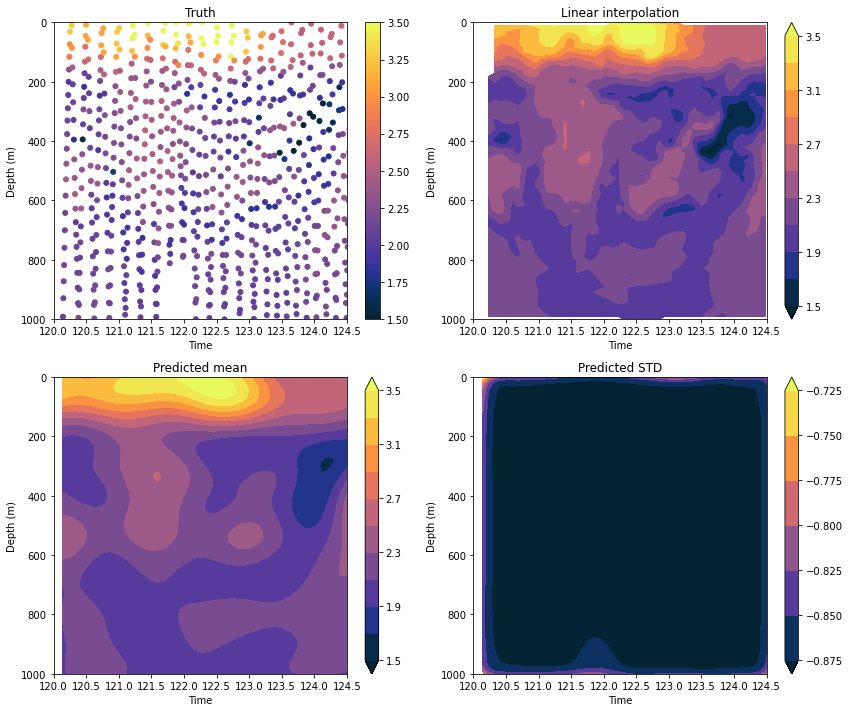

In [168]:

plt.figure(figsize=(12,10))


plt.subplot(221)
plt.scatter(time_sel, 
            pressure_sel, 
            c = temperature_sel, 
            s=25, cmap=cmo.thermal, vmin=1.5, vmax=3.5)
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Truth')


plt.subplot(222)
plt.contourf(Tg, Pg, temp_lin_grid[:,:,0],
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Linear interpolation')


plt.subplot(223)
plt.contourf(Tg, Pg, mean.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted mean')

plt.subplot(224)
plt.contourf(Tg, Pg, np.log10(cov.reshape(Tg.shape)**0.5),
            cmap=cmo.thermal, extend='both', 
             )
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted STD')

plt.tight_layout()

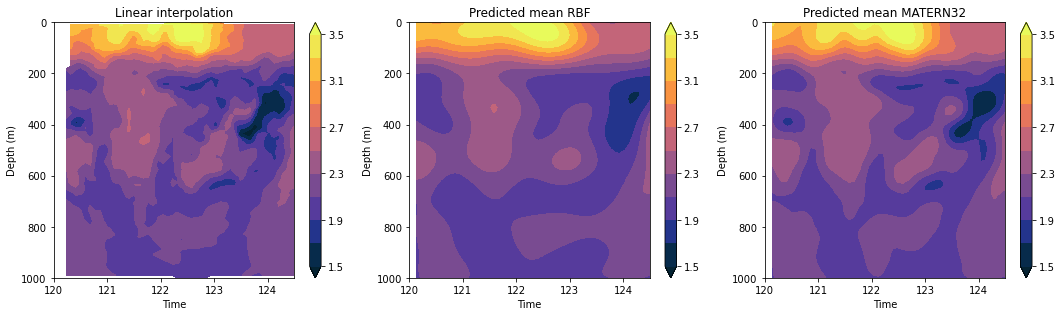

In [180]:

plt.figure(figsize=(15,4.5))


plt.subplot(131)
plt.contourf(Tg, Pg, temp_lin_grid[:,:,0],
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Linear interpolation')


plt.subplot(132)
plt.contourf(Tg, Pg, meanRBF.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted mean RBF')

plt.subplot(133)
plt.contourf(Tg, Pg, meanMATERN32.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Predicted mean MATERN32')

plt.tight_layout()

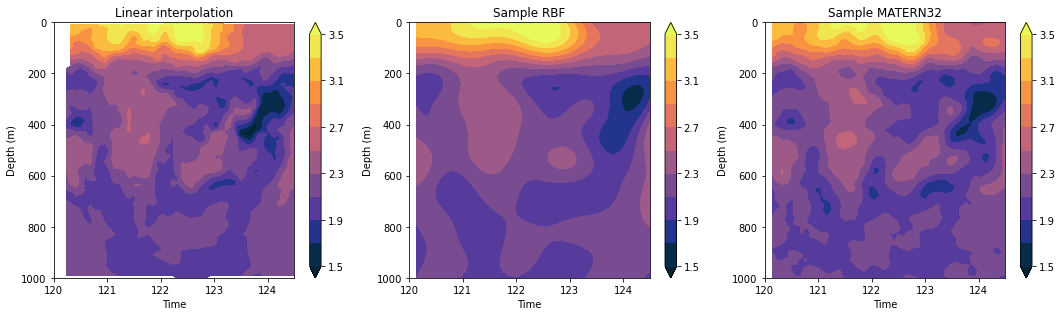

In [194]:

plt.figure(figsize=(15,4.5))


plt.subplot(131)
plt.contourf(Tg, Pg, temp_lin_grid[:,:,0],
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Linear interpolation')


plt.subplot(132)
plt.contourf(Tg, Pg, sampRBF.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Sample RBF')

plt.subplot(133)
plt.contourf(Tg, Pg, sampMATERN32.reshape(Tg.shape),
             levels=np.linspace(1.5, 3.5,11),
            vmin=1.5, vmax=3.5, cmap=cmo.thermal, extend='both')
plt.colorbar()

plt.xlim([120, 124.5])
plt.ylim([0, 1000])

plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Sample MATERN32')

plt.tight_layout()

In [184]:
mMATERN32.posterior_samples_f()

(5000, 1)

In [185]:
meanMATERN32.shape

(5000, 1)